
# üíé Diamantanalys f√∂r Guldfynd

## Bakgrund
Guldfynd √§r ett f√∂retag specialiserat p√• smycken av guld och silver. F√∂retaget √∂verv√§ger att ut√∂ka sitt sortiment till att √§ven omfatta diamanter. Som dataanalytiker p√• IT-avdelningen har du f√•tt i uppdrag att analysera ett tillg√§ngligt diamant-dataset f√∂r att identifiera insikter som kan v√§gleda verksamhetens investeringsbeslut.

Syftet:
- Identifiera faktorer som p√•verkar diamantpriser.
- F√∂rst√• f√∂rdelningen av olika diamantkvaliteter.
- Skapa en grund f√∂r rekommendationer kring sortimentsstrategi.


## Inneh√•llsf√∂rteckning
- Bakgrund
- Syftet
- Inneh√•llsf√∂rteckning
- Datapreparation

-- Analysen --
- ‚ùì Biblotek + Code Cleaning
- üîç Gruppering
- üîç Visualiseringar

Visualiseringar visar:
1. Pris vs Vikt (Carat)
2. Pris per F√§rg
3. Pris per Klarhet
4. Pris per Slipkvalitet (Cut)
5. F√∂rdelning: Cut
6. F√∂rdelning: Clarity

- üìà Prisf√∂rdelning (Pris x Antal) + (Antal Carat)
- üìä Sammanfattande Insikter
- üìå Executive Summary ( F√∂rslag till Guldfynds ledning: )


## Datapreparation
Vi b√∂rjar med att ladda in datan, unders√∂ka dess struktur och rensa bort saknade v√§rden f√∂r att m√∂jligg√∂ra en p√•litlig analys.

## ‚ùì Biblotek + Code Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

## Data Loading and Initial Cleaning
# Load data and handle missing values
df = pd.read_excel('diamonds.xlsx')
df_clean = df.dropna().copy()

print(f"Original dataset: {len(df)} rows")
print(f"After removing NaN: {len(df_clean)} rows")
print(f"Columns: {list(df_clean.columns)}")

## Data Quality Cleaning
# Define columns to validate
physical_cols = ['carat', 'price', 'x', 'y', 'z']
existing_cols = [col for col in physical_cols if col in df_clean.columns]

# Track removal statistics
removal_log = {}

def log_removal(description: str, before_count: int, after_count: int) -> None:
    """Helper function to log data removal."""
    removed = before_count - after_count
    removal_log[description] = removed
    print(f"{description}: {removed} rows removed")

# Remove zero values in physical measurements
if existing_cols:
    before = len(df_clean)
    df_clean = df_clean[(df_clean[existing_cols] != 0).all(axis=1)]
    log_removal("Zero values in physical measurements", before, len(df_clean))

# Clean depth measurements (remove >1% deviation)
if all(col in df_clean.columns for col in ['x', 'y', 'z', 'depth']):
    before = len(df_clean)
    
    # Calculate expected depth percentage
    avg_diameter = (df_clean['x'] + df_clean['y']) / 2
    df_clean['depth_calc'] = (df_clean['z'] / avg_diameter) * 100
    df_clean['depth_diff'] = abs(df_clean['depth_calc'] - df_clean['depth'])
    
    # Filter out diamonds with >1% depth deviation
    df_clean = df_clean[df_clean['depth_diff'] <= 1]
    log_removal(">1% depth deviation", before, len(df_clean))
    
    # Clean up temporary columns
    df_clean = df_clean.drop(['depth_calc', 'depth_diff'], axis=1)

# Clean length-width ratio (remove extreme ratios)
if all(col in df_clean.columns for col in ['x', 'y']):
    before = len(df_clean)
    
    # Calculate length-width ratio
    df_clean['lw_ratio'] = df_clean['x'] / df_clean['y']
    
    # Keep only diamonds with reasonable proportions (0.9-1.1 ratio)
    df_clean = df_clean[
        (df_clean['lw_ratio'] >= 0.9) & 
        (df_clean['lw_ratio'] <= 1.1)
    ]
    log_removal("Length/width ratio outside 0.9-1.1", before, len(df_clean))
    
    # Clean up temporary column
    df_clean = df_clean.drop('lw_ratio', axis=1)

## Cleaning Summary
initial_count = len(df)
final_count = len(df_clean)
total_removed = initial_count - final_count

print(f"\n{'='*50}")
print("DATA CLEANING SUMMARY")
print(f"{'='*50}")
print(f"Original rows: {initial_count:,}")
print(f"Final rows: {final_count:,}")
print(f"Total removed: {total_removed:,}")
print(f"Retention rate: {final_count/initial_count:.1%}")

print(f"\nDetailed removal breakdown:")
for reason, count in removal_log.items():
    percentage = (count / initial_count) * 100
    print(f"  ‚Ä¢ {reason}: {count:,} rows ({percentage:.1f}%)")

# Display first few rows
print(f"\nFirst 5 rows of cleaned data:")
df_clean.head()

Original dataset: 53940 rows
After removing NaN: 53864 rows
Columns: ['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
Zero values in physical measurements: 20 rows removed
>1% depth deviation: 80 rows removed
Length/width ratio outside 0.9-1.1: 0 rows removed

DATA CLEANING SUMMARY
Original rows: 53,940
Final rows: 53,764
Total removed: 176
Retention rate: 99.7%

Detailed removal breakdown:
  ‚Ä¢ Zero values in physical measurements: 20 rows (0.0%)
  ‚Ä¢ >1% depth deviation: 80 rows (0.1%)
  ‚Ä¢ Length/width ratio outside 0.9-1.1: 0 rows (0.0%)

First 5 rows of cleaned data:


Unnamed: 0  carat        cut color clarity  depth  table  price     x  \
0           1   0.23      Ideal     E     SI2   61.5   55.0  326.0  3.95   
1           2   0.21    Premium     E     SI1   59.8   61.0  326.0  3.89   
2           3   0.23       Good     E     VS1   56.9   65.0  327.0  4.05   
4           5   0.31       Good     J     SI2   63.3   58.0  335.0  4.34   
5           6   0.24  Very Good     J    VVS2   62.8   57.0  336.0  3.94   

      y     z  
0  3.98  2.43  
1  3.84  2.31  
2  4.07  2.31  
4  4.35  2.75  
5  3.96  2.48

## üîç Gruppering

In [2]:
## Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

## Data Loading and Initial Cleaning
# Load data and handle missing values
df = pd.read_excel('diamonds.xlsx')
df_clean = df.dropna().copy()

print(f"Original dataset: {len(df)} rows")
print(f"After removing NaN: {len(df_clean)} rows")
print(f"Columns: {list(df_clean.columns)}")

## Data Quality Cleaning
# Define columns to validate
physical_cols = ['carat', 'price', 'x', 'y', 'z']
existing_cols = [col for col in physical_cols if col in df_clean.columns]

# Track removal statistics
removal_log = {}

def log_removal(description: str, before_count: int, after_count: int) -> None:
    """Helper function to log data removal."""
    removed = before_count - after_count
    removal_log[description] = removed
    print(f"{description}: {removed} rows removed")

# Remove zero values in physical measurements
if existing_cols:
    before = len(df_clean)
    df_clean = df_clean[(df_clean[existing_cols] != 0).all(axis=1)]
    log_removal("Zero values in physical measurements", before, len(df_clean))

# Clean depth measurements (remove >1% deviation)
if all(col in df_clean.columns for col in ['x', 'y', 'z', 'depth']):
    before = len(df_clean)
    
    # Calculate expected depth percentage
    avg_diameter = (df_clean['x'] + df_clean['y']) / 2
    df_clean['depth_calc'] = (df_clean['z'] / avg_diameter) * 100
    df_clean['depth_diff'] = abs(df_clean['depth_calc'] - df_clean['depth'])
    
    # Filter out diamonds with >1% depth deviation
    df_clean = df_clean[df_clean['depth_diff'] <= 1]
    log_removal(">1% depth deviation", before, len(df_clean))
    
    # Clean up temporary columns
    df_clean = df_clean.drop(['depth_calc', 'depth_diff'], axis=1)

# Clean length-width ratio (remove extreme ratios)
if all(col in df_clean.columns for col in ['x', 'y']):
    before = len(df_clean)
    
    # Calculate length-width ratio
    df_clean['lw_ratio'] = df_clean['x'] / df_clean['y']
    
    # Keep only diamonds with reasonable proportions (0.9-1.1 ratio)
    df_clean = df_clean[
        (df_clean['lw_ratio'] >= 0.9) & 
        (df_clean['lw_ratio'] <= 1.1)
    ]
    log_removal("Length/width ratio outside 0.9-1.1", before, len(df_clean))
    
    # Clean up temporary column
    df_clean = df_clean.drop('lw_ratio', axis=1)

## Cleaning Summary
initial_count = len(df)
final_count = len(df_clean)
total_removed = initial_count - final_count

print(f"\n{'='*50}")
print("DATA CLEANING SUMMARY")
print(f"{'='*50}")
print(f"Original rows: {initial_count:,}")
print(f"Final rows: {final_count:,}")
print(f"Total removed: {total_removed:,}")
print(f"Retention rate: {final_count/initial_count:.1%}")

print(f"\nDetailed removal breakdown:")
for reason, count in removal_log.items():
    percentage = (count / initial_count) * 100
    print(f"  ‚Ä¢ {reason}: {count:,} rows ({percentage:.1f}%)")

# Display first few rows
print(f"\nFirst 5 rows of cleaned data:")
df_clean.head()

## Group Analysis - Price by Categories
print("Analyzing price patterns by categorical variables...")

# Calculate average prices by different categories
price_by_color = df_clean.groupby("color")["price"].mean().sort_index()
price_by_clarity = df_clean.groupby("clarity")["price"].mean().sort_index()
price_by_cut = df_clean.groupby("cut")["price"].mean().sort_index()

# Create GIA-style cut mapping for standardization
cut_mapping = {
    "Ideal": "Excellent",
    "Premium": "Very Good",
    "Very Good": "Good", 
    "Good": "Fair",
    "Fair": "Poor"
}
df_clean["cut_gia"] = df_clean["cut"].map(cut_mapping)
price_by_cut_gia = df_clean.groupby("cut_gia")["price"].mean().sort_index()

print("Average prices calculated for:")
print(f"  ‚Ä¢ Colors: {len(price_by_color)} categories")
print(f"  ‚Ä¢ Clarity grades: {len(price_by_clarity)} categories") 
print(f"  ‚Ä¢ Cut grades: {len(price_by_cut)} categories")

## Group Analysis - Numerical Variable Binning
print("\nCreating binned categories for numerical variables...")

# Create tertile bins for continuous variables
depth_bins = pd.qcut(df_clean["depth"], q=3, labels=["Low", "Medium", "High"])
table_bins = pd.qcut(df_clean["table"], q=3, labels=["Low", "Medium", "High"])
carat_bins = pd.qcut(df_clean["carat"], q=3, labels=["Low", "Medium", "High"])

# Count distributions
depth_counts = depth_bins.value_counts().sort_index()
table_counts = table_bins.value_counts().sort_index()
carat_counts = carat_bins.value_counts().sort_index()

# Categorical variable counts
cut_counts = df_clean["cut"].value_counts()
clarity_counts = df_clean["clarity"].value_counts()

print("Binned variable distributions:")
print(f"  ‚Ä¢ Depth: {dict(depth_counts)}")
print(f"  ‚Ä¢ Table: {dict(table_counts)}")
print(f"  ‚Ä¢ Carat: {dict(carat_counts)}")


Original dataset: 53940 rows
After removing NaN: 53864 rows
Columns: ['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
Zero values in physical measurements: 20 rows removed
>1% depth deviation: 80 rows removed
Length/width ratio outside 0.9-1.1: 0 rows removed

DATA CLEANING SUMMARY
Original rows: 53,940
Final rows: 53,764
Total removed: 176
Retention rate: 99.7%

Detailed removal breakdown:
  ‚Ä¢ Zero values in physical measurements: 20 rows (0.0%)
  ‚Ä¢ >1% depth deviation: 80 rows (0.1%)
  ‚Ä¢ Length/width ratio outside 0.9-1.1: 0 rows (0.0%)

First 5 rows of cleaned data:
Analyzing price patterns by categorical variables...
Average prices calculated for:
  ‚Ä¢ Colors: 7 categories
  ‚Ä¢ Clarity grades: 8 categories
  ‚Ä¢ Cut grades: 5 categories

Creating binned categories for numerical variables...
Binned variable distributions:
  ‚Ä¢ Depth: {'Low': np.int64(19367), 'Medium': np.int64(18013), 'High': np.int64(16384)}
  ‚Ä¢ Table: {'Low': 

## üîé Visualiseringar

Creating main visualization dashboard...


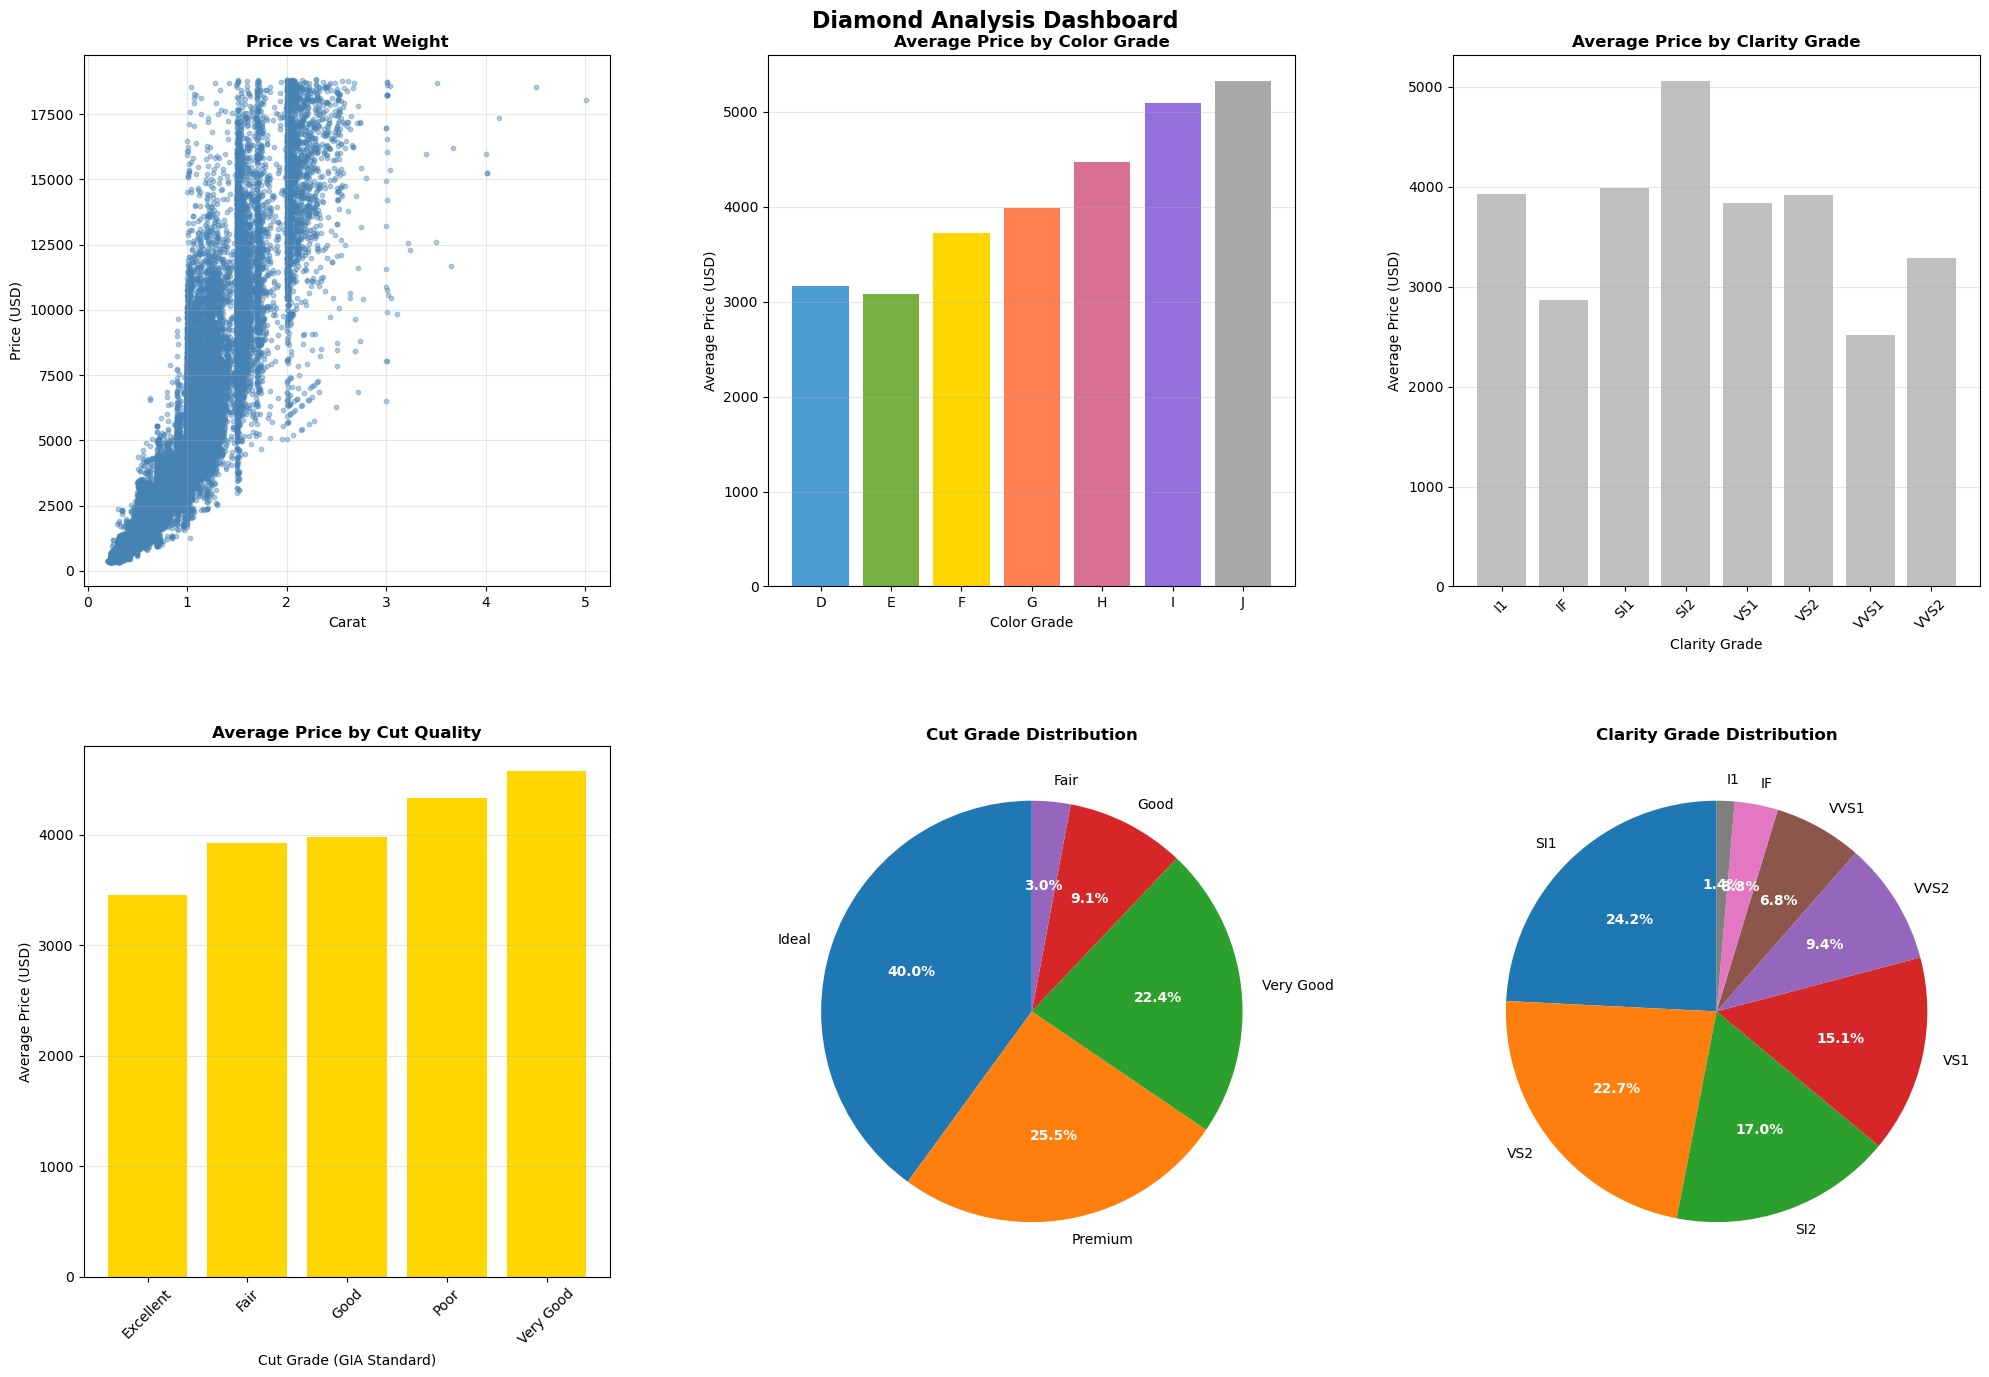

Analyzing price distribution...


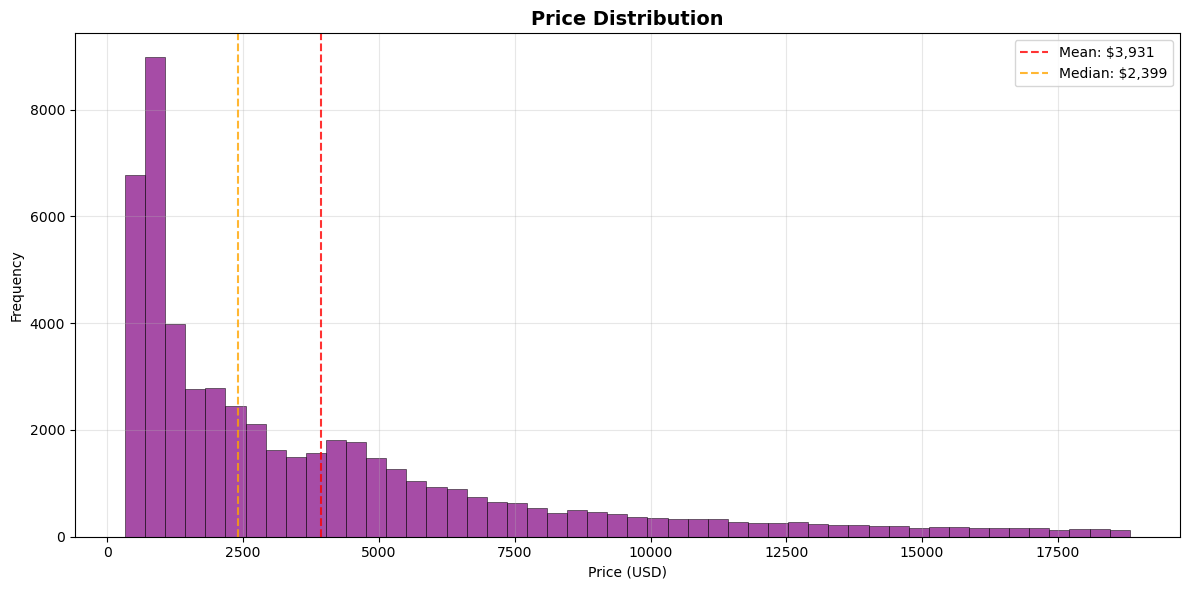

Price statistics:
  ‚Ä¢ Mean: $3,931
  ‚Ä¢ Median: $2,399
  ‚Ä¢ Min: $326
  ‚Ä¢ Max: $18,823


In [3]:
print("Creating main visualization dashboard...")

# Set up the subplot grid
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Diamond Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)

# 1. Price vs Carat scatter plot
axes[0, 0].scatter(df_clean["carat"], df_clean["price"], alpha=0.4, color='steelblue', s=10)
axes[0, 0].set_title("Price vs Carat Weight", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Carat")
axes[0, 0].set_ylabel("Price (USD)")
axes[0, 0].grid(True, alpha=0.3)

# 2. Average price by color
color_palette = {
    'D': '#4B9CD3', 'E': '#76B041', 'F': '#FFD700', 'G': '#FF7F50',
    'H': '#D87093', 'I': '#9370DB', 'J': '#A9A9A9'
}
bar_colors = [color_palette.get(color, 'gray') for color in price_by_color.index]

axes[0, 1].bar(price_by_color.index, price_by_color.values, color=bar_colors)
axes[0, 1].set_title("Average Price by Color Grade", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Color Grade")
axes[0, 1].set_ylabel("Average Price (USD)")
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Average price by clarity
axes[0, 2].bar(price_by_clarity.index, price_by_clarity.values, color="silver")
axes[0, 2].set_title("Average Price by Clarity Grade", fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel("Clarity Grade")
axes[0, 2].set_ylabel("Average Price (USD)")
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Average price by cut (GIA standardized)
axes[1, 0].bar(price_by_cut_gia.index, price_by_cut_gia.values, color="gold")
axes[1, 0].set_title("Average Price by Cut Quality", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("Cut Grade (GIA Standard)")
axes[1, 0].set_ylabel("Average Price (USD)")
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. Cut distribution pie chart
wedges, texts, autotexts = axes[1, 1].pie(cut_counts.values, labels=cut_counts.index, 
                                         autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Cut Grade Distribution", fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 6. Clarity distribution pie chart  
wedges, texts, autotexts = axes[1, 2].pie(clarity_counts.values, labels=clarity_counts.index,
                                         autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title("Clarity Grade Distribution", fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

## Distribution Analysis - Price
print("Analyzing price distribution...")

plt.figure(figsize=(12, 6))
plt.hist(df_clean["price"], bins=50, color='purple', alpha=0.7, edgecolor='black', linewidth=0.5)
plt.title("Price Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Price (USD)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Add summary statistics to the plot
price_mean = df_clean["price"].mean()
price_median = df_clean["price"].median()
plt.axvline(price_mean, color='red', linestyle='--', alpha=0.8, label=f'Mean: ${price_mean:,.0f}')
plt.axvline(price_median, color='orange', linestyle='--', alpha=0.8, label=f'Median: ${price_median:,.0f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Price statistics:")
print(f"  ‚Ä¢ Mean: ${price_mean:,.0f}")
print(f"  ‚Ä¢ Median: ${price_median:,.0f}")
print(f"  ‚Ä¢ Min: ${df_clean['price'].min():,.0f}")
print(f"  ‚Ä¢ Max: ${df_clean['price'].max():,.0f}")


## üìà Prisf√∂rdelning (Pris x Antal) + (Antal Carat)

Analyzing carat weight distribution...


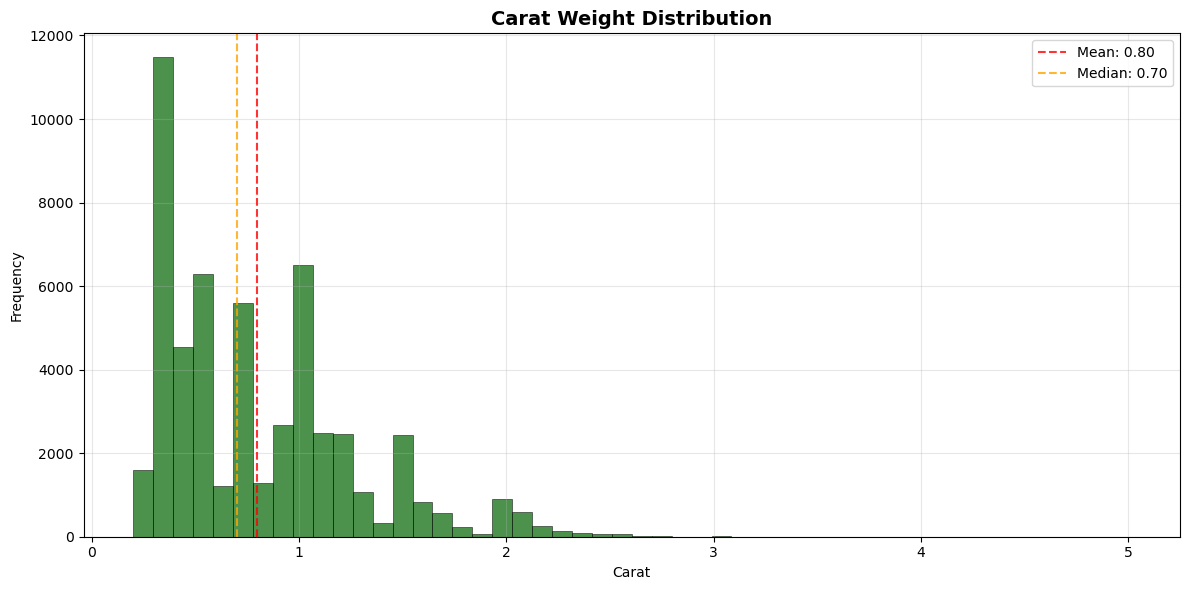

Carat statistics:
  ‚Ä¢ Mean: 0.80
  ‚Ä¢ Median: 0.70
  ‚Ä¢ Min: 0.20
  ‚Ä¢ Max: 5.01

Final dataset summary:
Shape: (53764, 12)
Memory usage: 14.6 MB

Summary statistics for numerical variables:


In [4]:
print("Analyzing carat weight distribution...")

plt.figure(figsize=(12, 6))
plt.hist(df_clean["carat"], bins=50, color='darkgreen', alpha=0.7, edgecolor='black', linewidth=0.5)
plt.title("Carat Weight Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Carat")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Add summary statistics
carat_mean = df_clean["carat"].mean()  
carat_median = df_clean["carat"].median()
plt.axvline(carat_mean, color='red', linestyle='--', alpha=0.8, label=f'Mean: {carat_mean:.2f}')
plt.axvline(carat_median, color='orange', linestyle='--', alpha=0.8, label=f'Median: {carat_median:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Carat statistics:")
print(f"  ‚Ä¢ Mean: {carat_mean:.2f}")
print(f"  ‚Ä¢ Median: {carat_median:.2f}")
print(f"  ‚Ä¢ Min: {df_clean['carat'].min():.2f}")
print(f"  ‚Ä¢ Max: {df_clean['carat'].max():.2f}")

## Summary Statistics
print("\nFinal dataset summary:")
print(f"Shape: {df_clean.shape}")
print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display summary statistics for numerical columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
summary_stats = df_clean[numeric_cols].describe()
print(f"\nSummary statistics for numerical variables:")

## üìä Sammanfattande insikter

Efter att ha analyserat diamantdatasetet framtr√§der f√∂ljande centrala observationer:

1. **Carat har starkast koppling till priset**  
   Ju h√∂gre carat, desto h√∂gre pris ‚Äì med ett tydligt icke-linj√§rt samband. Det finns ett s√§rskilt prishopp runt 1.0 carat och upp√•t.

2. **Slipkvalitet ("cut") har stor p√•verkan p√• priset**  
   Diamanter med h√∂gre slipkvalitet (t.ex. "Excellent", "Very Good") tenderar att ha h√∂gre pris √§n motsvarande stenar med s√§mre slip, √§ven vid samma vikt.

3. **F√§rg och klarhet p√•verkar ‚Äì men mer nyanserat**  
   B√§ttre f√§rg (n√§rmare D) och h√∂g klarhet (t.ex. IF, VVS1) ger generellt h√∂gre priser, men variationen inom kategorierna √§r betydande.

4. **St√∂rre delen av diamanterna ligger i ett "mittsegment"**  
   De flesta diamanter har:
   - Vikt mellan **0.9‚Äì1.6 carat**
   - Mellanniv√•er f√∂r bord och djup
   - Medelh√∂g klarhet och f√§rg  
   Detta kan spegla b√•de utbud och efterfr√•gan p√• marknaden.

5. **Prisspridning inom kategorier tyder p√• fler dolda faktorer**  
   Betydande variationer i pris finns √§ven inom samma f√§rg, klarhet eller vikt ‚Äì vilket indikerar att exempelvis certifiering, fluorescens eller marknadsl√§ge ocks√• spelar in.

(F√∂r dig som inte vet vad fluorescens √§r.. 
(AI F√∂rklaring: Fluorescens i diamanter syftar p√• diamantens f√∂rm√•ga att avge ett synligt ljus (ofta bl√•tt) n√§r den uts√§tts f√∂r UV-ljus.))


## üìå Executive Summary

**Insikter:**
- Prisniv√•n p√• diamanter √∂kar kraftigt med √∂kad carat-vikt, vilket tyder p√• att vikt √§r en avg√∂rande faktor f√∂r v√§rdet.
- Slipkvalitet ("cut"), f√§rg och klarhet p√•verkar priset i varierande grad. S√§rskilt slipkvaliteten har stark korrelation med prisniv√•er.
- Majoriteten av diamanterna i datasetet ligger inom viktspannet 0.7‚Äì1.2 carat, vilket indikerar var efterfr√•gan √§r som st√∂rst p√• marknaden.
- F√∂rdelningen av djup (depth) och bord (table) ligger ocks√• i ett tydligt mellansegment, vilket antyder industristandarder f√∂r proportioner.
- Betydande prisskillnader f√∂rekommer √§ven inom samma kategori (t.ex. f√§rg eller klarhet), vilket antyder att andra faktorer som certifiering, symmetri eller marknadsl√§ge ocks√• p√•verkar priset.

**Rekommendationer:**
- Fokusera p√• diamanter mellan 0.7 ‚Äì 1.2 carat, d√§r marginalerna verkar vara b√§st.
- Clarity VS2‚ÄìSI1 och color G‚ÄìH ger b√§st balans mellan pris och kvalitet.
- "Excellent" och "Very Good" cut rekommenderas d√• de ofta erbjuder h√∂g kvalitet till rimligt pris.
- "Very Good" cut ger ibland h√∂gt pris utan proportionellt h√∂gre v√§rde.
- Undvik mycket stora diamanter (>2 carat) i f√∂rsta skedet ‚Äì dessa √§r f√• och dyra.

Denna analys ger ett datadrivet underlag f√∂r produkturval, sortimentstrategi och priss√§ttning vid en eventuell expansion till diamantf√∂rs√§ljning.